# Read in Data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
%matplotlib inline
import re
import string
import random
import plotly.express as px
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import warnings

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.rcParams['axes.facecolor'] = 'white'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seanb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#find df at https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction
df = pd.read_csv("fake_job_postings.csv")

Define ML problems



    [ ] Choose your target. Which column in your tabular dataset will you predict?
     - I will be predicting the fraudulent column
    [ ] Is your problem regression or classification?
     - Classification
    [ ] How is your target distributed?
        Classification: How many classes? Are the classes imbalanced?
           - 2, it is binary, and heavily imbalanced. The majority class is 95%
    [ ] Choose your evaluation metric(s).
        Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
        - Recall is what I'll be using.

    [ ] Choose which observations you will use to train, validate, and test your model.
        Are some observations outliers? Will you exclude them?
            - I would like to use all of them to TVT.
        Will you do a random split or a time-based split?
            - random
    [ ] Begin to clean and explore your data.
    [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?


Day One: Spent tutorialing text parsing so I can get metrics from heavy text data.

I noticed most fraudulents have a lot of NaN's 
 - If row has more than 8 NaN's - assume it is fraudulent is a good guess

In [3]:
#Baseline - unuseable because of imbalance
df['fraudulent'].value_counts(normalize=True)

0    0.951566
1    0.048434
Name: fraudulent, dtype: float64

In [4]:
    #Create new column of missing data count
    missing_data = []
    for i in range(len(df)) :
        missing_data.append(df.iloc[i].isnull().sum())
    df['missing_data'] = missing_data

# Create graphs of missing data

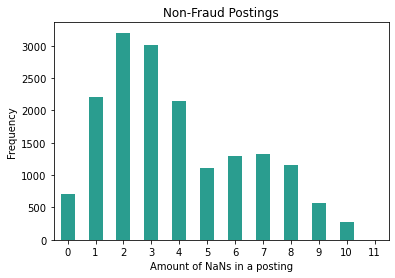

In [5]:
onlyfraud = df[df['fraudulent'] == 1]
notfraud = df[df['fraudulent'] == 0]
fake = pd.Series(notfraud['missing_data'].value_counts().sort_index())

plt.xlabel('Amount of NaNs in a posting')
plt.ylabel('Frequency')

ax  = fake.plot.bar(title= 'Non-Fraud Postings', rot=0, color='#2a9d8f')
plt.grid(False)
ax.set_facecolor('white')

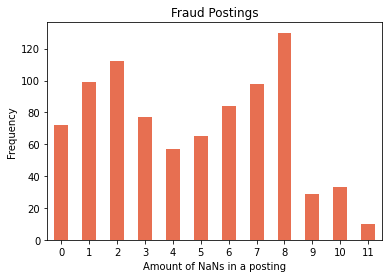

In [6]:
fake2 = pd.Series(onlyfraud['missing_data'].value_counts().sort_index())

plt.xlabel('Amount of NaNs in a posting')
plt.ylabel('Frequency')

ax = fake2.plot.bar(title= 'Fraud Postings', rot=0, color='#e76f51');
plt.grid(False)
ax.set_facecolor('white')

# Some prelimenary questioning
### 1) Text Pre Processing
### 2) text parsing and Exploratory Data Analysis
### 3) Text Representation & Feature Engineering
### 4) Modeling and or pattern mining

## I will begin with text wrangling
Step 1 : Data Preprocessing

- Tokenization — convert sentences to words
- Removing unnecessary punctuation, tags
- Removing stop words — frequent words such as ”the”, ”is”, etc. that do not have specific semantic
- Stemming — words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix.
- Lemmatization — Another approach to remove inflection by determining the part of speech and utilizing detailed database of the language.

Personal anecdote: By normalizing and wrangling all the text, I will inadvertenly be removing many grammar mistakes that are very important to analyzing a possible fraud posting. If time allows, I will compare a standard text wrangling below and a custom grammar allowance one perhaps.

I am going to combine a lot of these string columns together 

In [7]:
#!pip install spacy
#!pip install nltk
#!pip install wordcloud

In [8]:

warnings.filterwarnings("ignore")

# Imbalance Visualization

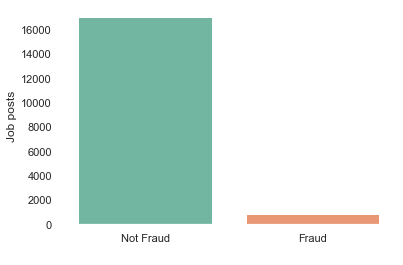

In [9]:
# Heavy Imbalance
sns.set(style="darkgrid")

ax = sns.countplot(df.fraudulent, palette="Set2")
ax.set_xticklabels(labels=['Not Fraud','Fraud'])
ax.set_xlabel(' ')
ax.set_ylabel('Job posts')

df.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)
plt.grid(False)
ax.set_facecolor('white')


## fill nan values, combine all string columns to be parsed into one big column

In [10]:
#Make 'text only' dataframe. drop columns from it i dont want to be parsed
columns = ['title','location','department','company_profile','description','requirements','benefits','required_experience','required_education','industry','function', 'fraudulent']

to_df = df.copy()

to_df = to_df[columns]

In [11]:
#fill NaN's for functions to operate
to_df.fillna(' ', inplace=True)

In [12]:
to_df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0


In [13]:
#Split location column by countries

def split(location):
    listsplit = location.split(',')
    return listsplit[0]

In [14]:
to_df['country'] = to_df.location.apply(split)

to_df



,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0,US
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0,NG


# Visualization of Fraud compared to Non fraud

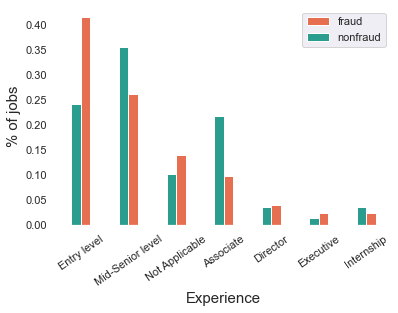

In [15]:
#Graph NORMALIZED comparison between fraud job experience and normal and see the differences

experience = dict(onlyfraud.required_experience.value_counts(normalize=True))
experiencenot = dict(notfraud.required_experience.value_counts(normalize=True))

plt.bar(experience.keys(), experience.values(), color='#e76f51', width = 0.2, align='edge', label="fraud")
plt.bar(experiencenot.keys(), experiencenot.values(), color = '#2a9d8f', width = -0.2, align='edge', label='nonfraud')
plt.legend()
ax = plt.axes()
plt.xlabel('Experience', size=15)
plt.ylabel('% of jobs', size=15)
plt.xticks(rotation=35)
ax.set_facecolor("white")
plt.grid(False)

plt.show()



In [16]:
#combine all text into a single column to begin text analysis


to_df['text']=to_df['title']+' '+to_df['location']+' '+to_df['company_profile']+' '+to_df['description']+' '+to_df['requirements']+' '+to_df['benefits']
del to_df['location']
del to_df['department']
del to_df['title']
del to_df['company_profile']
del to_df['description']
del to_df['requirements']
del to_df['benefits']
del to_df['required_experience']
del to_df['required_education']
del to_df['industry']
del to_df['function']
del to_df['country']






In [17]:
to_df

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
...,...,...
17875,0,"Account Director - Distribution CA, ON, Toron..."
17876,0,"Payroll Accountant US, PA, Philadelphia WebLin..."
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,"Graphic Designer NG, LA, Lagos Nemsia Studio..."


# Wordcloud comparison

In [18]:
#using a word cloud comparison we will see what jobs fraud and what jobs actual compare



fraudjobs_text = to_df[to_df['fraudulent'] == 1]
fraudjobs_text = fraudjobs_text.drop('fraudulent', axis=1)
notfraudjobs_text = to_df[to_df['fraudulent'] == 0]

text = " ".join(word for word in fraudjobs_text.text)


In [19]:
# Load library
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
#nltk.download('punkt')
# You will have to download the set of stop words the first time

#nltk.download('stopwords')
text = " ".join(word for word in fraudjobs_text.text)
text = text.strip().lower()
text =word_tokenize(text)

stop_words = stopwords.words('english')

text = [word for word in text if word not in stop_words]

# Fraud

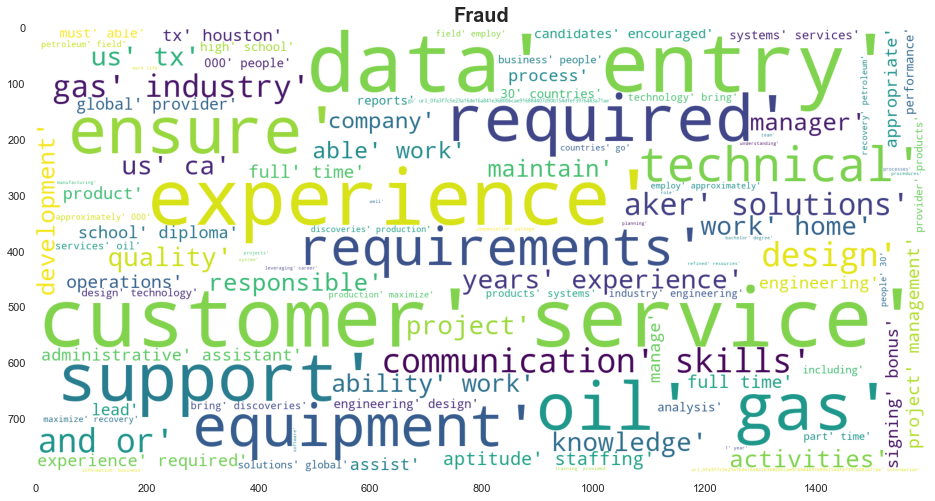

In [20]:
plt.figure(figsize = (16,14))
wc = WordCloud(background_color='white', min_font_size = 3,  max_words = 100 , width = 1600 , height = 800).generate(str(text))
plt.grid(False)
plt.title('Fraud', size=20, weight='bold')

plt.imshow(wc)

# Non Fraud

In [21]:
notfraudjobs_text = to_df[to_df['fraudulent'] == 0]

text = " ".join(word for word in notfraudjobs_text.text)
text = text.strip().lower()
text =word_tokenize(text)

stop_words = stopwords.words('english')

text = [word for word in text if word not in stop_words]

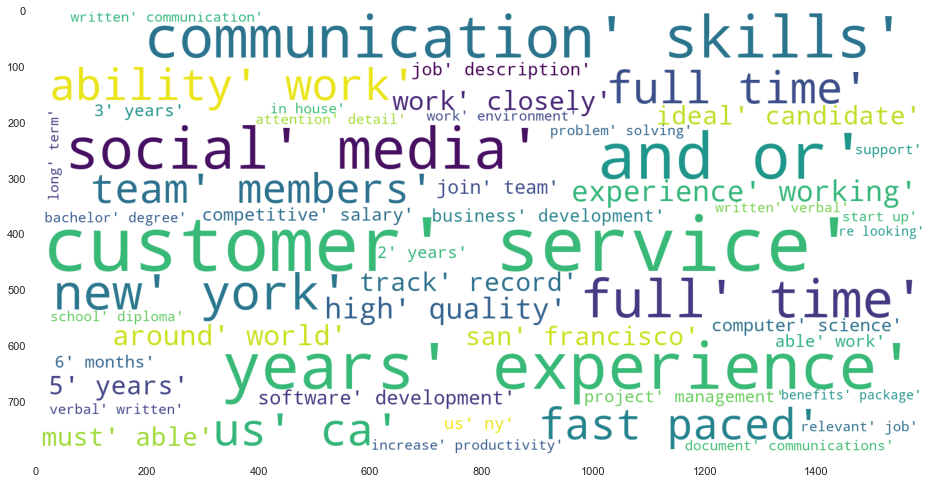

In [22]:
plt.figure(figsize = (16,14))
wc = WordCloud(background_color='white', min_font_size = 3,  max_words = 50 , width = 1600 , height = 800).generate(str(text))
plt.grid(False)
plt.imshow(wc)

# Begin Text Processing

In [23]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords

stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [25]:
#test
spacy_tokenizer("what? Hold on a second. I thought you were good bro..")


['hold', 'second', 'thought', 'good', 'bro', '..']

In [26]:

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()



# Create Bag of Words Vector with 3 word range

In [27]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))

# Train Val Test Split

In [28]:

train, test = train_test_split(to_df, train_size=0.80, test_size=0.20, 
                                stratify= to_df['fraudulent'], random_state=3)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                                stratify= train['fraudulent'], random_state=3)


In [29]:
features = 'text'
target = 'fraudulent'

In [30]:
X_train = train[features]
X_val = val[features]
X_test = test[features]
y_train = train[target]
y_val = val[target]
y_test = test[target]

# 

# Fit Log Regression with 1,3 Range

In [31]:
lrm = LogisticRegression(n_jobs=-1)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', lrm)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x00000213A65FE1C8>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x00000213957745E8>)),
                ('classifier', LogisticRegression(n_jobs=-1))])

Logistic Regression Accuracy: 0.9867179307934288
Logistic Regression Recall: 0.7266187050359713


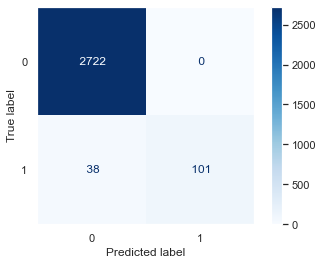

In [32]:
# Predicting with a test dataset
linpredicted = pipe.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, linpredicted))
print("Logistic Regression Recall:", recall_score(y_val, linpredicted))

plot_confusion_matrix(pipe, X_val, y_val, cmap='Blues', values_format=' ')
plt.grid(False)

In [33]:
print(len(bow_vector.vocabulary_.items()))

2175652


In [34]:
words = []

for word, ind in bow_vector.vocabulary_.items():

    words.append(word)
    
coefs = pd.DataFrame(words)
coefs.columns = ['word']
coefs.sort_index(inplace=True)

coefs['coefs'] = lrm.coef_[0]

most_relevant_words = coefs.iloc[np.argsort(coefs.coefs.abs())].tail(20)

most_relevant_words.sort_values('coefs', inplace=True)



In [35]:
def plot_impact(words, impacts):
    plt.figure(figsize=(12,10))
    pos_ind = (impacts > 0)
    position = np.arange(len(words))
    plt.barh(y=position[pos_ind], width=impacts[pos_ind], color='red')
    plt.barh(y=position[~pos_ind], width=impacts[~pos_ind], color='green')
    plt.yticks(position + 0.4 ,words)
    plt.title("Words with the largest impact on fraud prediction", fontsize=16, fontweight="bold")
    plt.grid(False)
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.show()

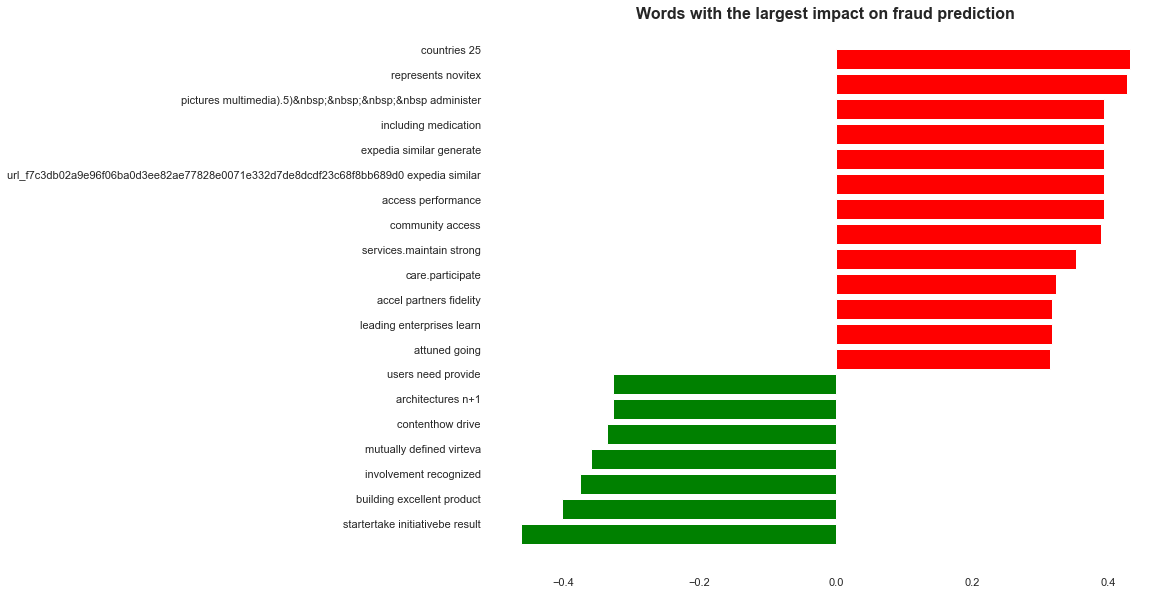

In [36]:
plot_impact(most_relevant_words.word.values, most_relevant_words.coefs.values)

In [37]:
lim = LinearRegression(n_jobs=-1)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', lrm)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x00000213BC458848>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x00000213957745E8>)),
                ('classifier', LogisticRegression(n_jobs=-1))])

# Fit Logistic Regression Model with 1,1 Range (superior)

In [38]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
lrm = LogisticRegression(n_jobs=-1)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', lrm)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x00000213BA05C5C8>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x00000213957745E8>)),
                ('classifier', LogisticRegression(n_jobs=-1))])

In [39]:
# Predicting with a test dataset
linpredicted = pipe.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, linpredicted))
print("Logistic Regression Recall:", recall_score(y_val, linpredicted))

Logistic Regression Accuracy: 0.9839217056973086
Logistic Regression Recall: 0.762589928057554


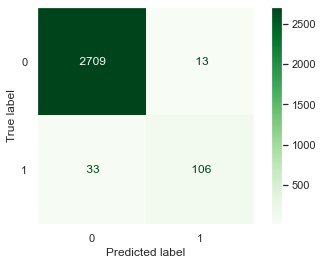

In [40]:

plot_confusion_matrix(pipe, X_val, y_val, cmap='Greens', values_format=' ')
plt.grid(False)

# FINAL TEST:

In [41]:


# Predicting with a test dataset
linpredicted = pipe.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, linpredicted))
print("Logistic Regression Recall:", recall_score(y_test, linpredicted))

Logistic Regression Accuracy: 0.9832214765100671
Logistic Regression Recall: 0.7109826589595376


# Coefficient Graph

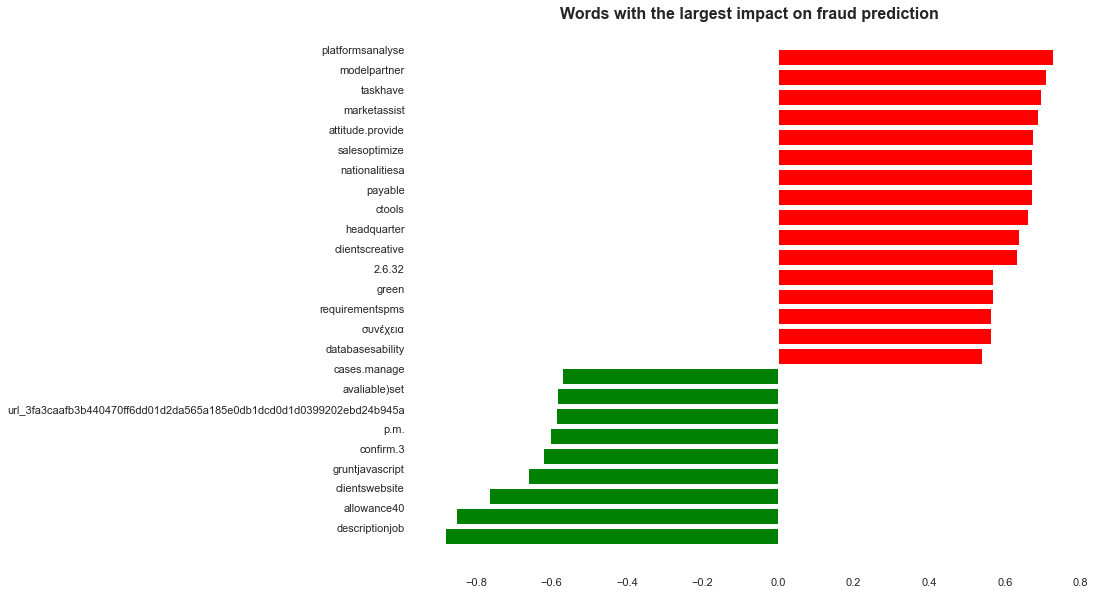

In [42]:
words = []

for word, ind in bow_vector.vocabulary_.items():

    words.append(word)
    
coefs = pd.DataFrame(words)
coefs.columns = ['word']
coefs.sort_index(inplace=True)

coefs['coefs'] = lrm.coef_[0]

most_relevant_words = coefs.iloc[np.argsort(coefs.coefs.abs())].tail(25)

most_relevant_words.sort_values('coefs', inplace=True)
plot_impact(most_relevant_words.word.values, most_relevant_words.coefs.values)


# Fit XGB Model

In [43]:

xgm = XGBClassifier(n_jobs=-1)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', xgm)])

# fitting our model.
pipe.fit(X_train,y_train)


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x00000213BC83A188>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x00000213957745E8>)),
                ('classifier', XGBClassifier(n_jobs=-1))])

In [44]:

# Predicting with a test dataset
xgpredicted = pipe.predict(X_val)

print("XGboost Classifier Accuracy:", accuracy_score(y_val, xgpredicted))
print("XGboost Classifier Recall:", recall_score(y_val, xgpredicted))


XGboost Regression Accuracy: 0.9723872771758126
XGboost Regression Recall: 0.43884892086330934


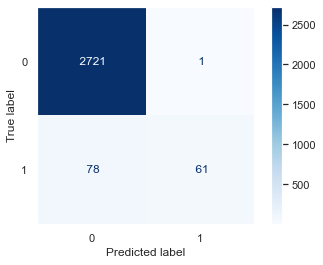

In [45]:
plot_confusion_matrix(pipe, X_val, y_val, cmap='Blues', values_format=' ')
plt.grid(False)

# Make Traditional Numeric Dataframe

In [46]:
notextdf = df.copy()
notextdf = df.drop(['company_profile', 'description', 'requirements', 'benefits'], axis = 1)

In [47]:
notextdf.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'missing_data'],
      dtype='object')

In [48]:
train, test = train_test_split(notextdf, train_size=0.80, test_size=0.20, 
                                stratify= notextdf['fraudulent'], random_state=3)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                                stratify= train['fraudulent'], random_state=3)



In [49]:
features = ['title', 'location', 'department', 'salary_range',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function', 'missing_data']
target = 'fraudulent'

X_train = train[features]
X_val = val[features]
X_test = test[features]
y_train = train[target]
y_val = val[target]
y_test = test[target]

# Fit Logression Model on traditional

In [50]:


lr = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    LogisticRegression(n_jobs=-1)
)

lr.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['title', 'location', 'department',
                                      'salary_range', 'employment_type',
                                      'required_experience',
                                      'required_education', 'industry',
                                      'function'],
                                mapping=[{'col': 'title',
                                          'data_type': dtype('O'),
                                          'mapping': Vice President of Talent and Employee Experience                  1
Product Support Representative                                    2
Senior JavaScript Developer                                       3
Sales & Mar...
Advertising               20
Education                 21
Art/Creative              22
Writing/Editing           23
Production                24
Training                  25
Design                    26
Distribution              27
Produc

In [51]:
# Predicting with a test dataset
linpredicted = lr.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, linpredicted))
print("Logistic Regression Recall:", recall_score(y_val, linpredicted))

Logistic Regression Accuracy: 0.9514155889549109
Logistic Regression Recall: 0.007194244604316547


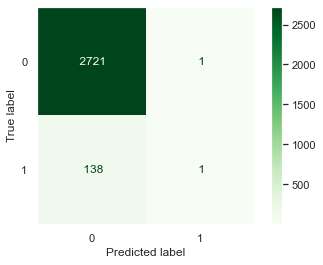

In [52]:
plot_confusion_matrix(lr, X_val, y_val, cmap='Greens', values_format=' ')
plt.grid(False)

# Fit XGB Model on Traditional

In [53]:

xb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    XGBClassifier(n_jobs=-1)
)

xb.fit(X_train, y_train)

# Predicting with a test dataset
xbpredicted = xb.predict(X_val)

print("XGBoost Classifier Accuracy:", accuracy_score(y_val, xbpredicted))
print("XGBoost Classifier Recall:", recall_score(y_val, xbpredicted))

XGBoost Classifier Accuracy: 0.9605033205173017
XGBoost Classifier Recall: 0.23741007194244604


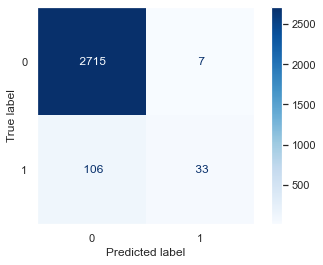

In [54]:
plot_confusion_matrix(xb, X_val, y_val, cmap='Blues', values_format=' ')
plt.grid(False)

# Final test score for Traditional

In [55]:
# Predicting with a test dataset
xbpredicted = xb.predict(X_test)

print("XGBoost Classifier Accuracy:", accuracy_score(y_test, xbpredicted))
print("XGBoost Classifier Recall:", recall_score(y_test, xbpredicted))

XGBoost Classifier Accuracy: 0.9572147651006712
XGBoost Classifier Recall: 0.15028901734104047


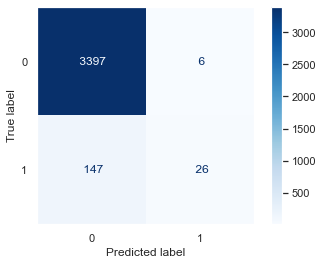

In [56]:
plot_confusion_matrix(xb, X_test, y_test, cmap='Blues', values_format=' ')
plt.grid(False)